In [26]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency

sns.set_context("talk")
plt.style.use("ggplot")
pd.set_option("display.max_columns", 50)



In [27]:
# LOAD AND MERGE DATA (Correct filenames)
weather = pd.read_csv("weather-data.csv")
crime   = pd.read_csv("crime-data.csv")
pop     = pd.read_csv("chicago_population_named.csv")

# Clean and prepare
weather["date"] = pd.to_datetime(weather["datetime"]).dt.date
crime["DateTime"] = pd.to_datetime(crime["Date"], errors="coerce")
crime["date"] = crime["DateTime"].dt.date
crime["hour"] = crime["DateTime"].dt.hour
crime["dayofweek"] = crime["DateTime"].dt.day_name()
crime["month"] = crime["DateTime"].dt.month
crime["year_month"] = crime["DateTime"].dt.to_period("M")

# Merge datasets into 'df'
df = pd.merge(crime, weather, on="date", how="inner")
df = pd.merge(df, pop, on="Community Area", how="left")


df["season"] = (df["month"] % 12 // 3 + 1).map({
    1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"
})



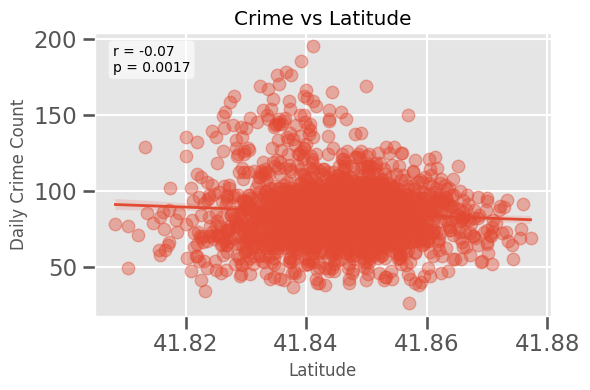

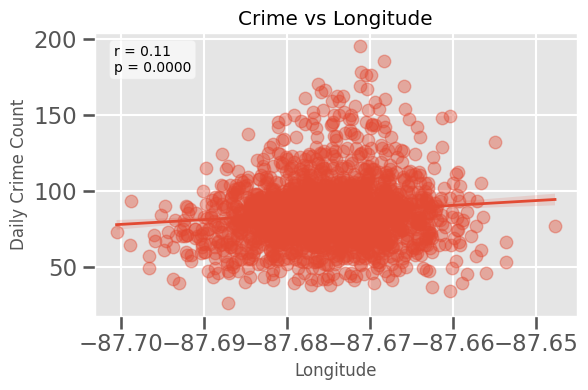

<ipython-input-28-158432339b79>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="season", y="temp", data=df, palette="Set3")


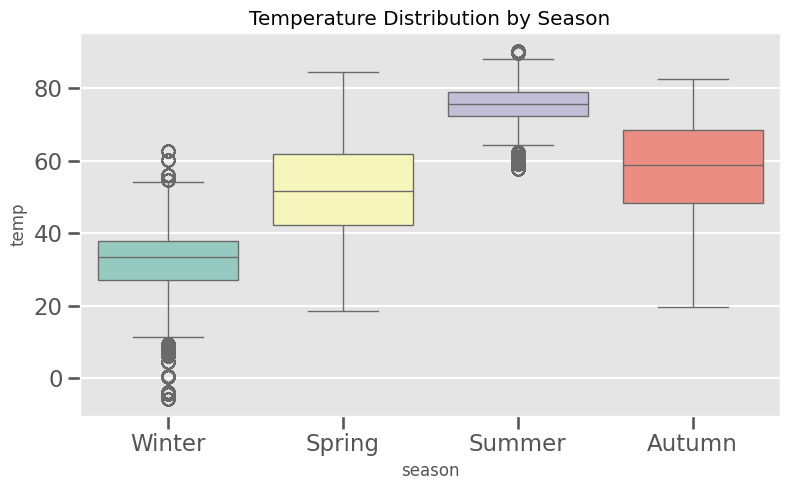

In [28]:
# =========================================================
#  LOCATION VARIABLES VS CRIME (FIXED)
# =========================================================

# Calculate daily latitude and longitude averages
loc_daily = df.groupby("date").agg(
    crimes = ("ID", "size"),
    lat = ("Latitude", "mean"),
    lon = ("Longitude", "mean")
).reset_index()

# Scatterplot fonksiyonu (annotate r/p ile)
def annotate_r_p(ax, x, y, pos=(0.04, 0.96)):
    r, p = pearsonr(x, y)
    ax.text(pos[0], pos[1], f"r = {r:.2f}\np = {p:.4f}",
            transform=ax.transAxes, va="top",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.65))

# draw the graphs
for loc, label in [("lat", "Latitude"), ("lon", "Longitude")]:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.regplot(x=loc, y="crimes", data=loc_daily,
                scatter_kws=dict(alpha=0.4), line_kws=dict(lw=2), ax=ax)
    annotate_r_p(ax, loc_daily[loc], loc_daily["crimes"])
    ax.set_xlabel(label); ax.set_ylabel("Daily Crime Count")
    ax.set_title(f"Crime vs {label}")
    plt.tight_layout(); plt.show()



plt.figure(figsize=(8,5))
sns.boxplot(x="season", y="temp", data=df, palette="Set3")
plt.title("Temperature Distribution by Season")
plt.tight_layout(); plt.show()


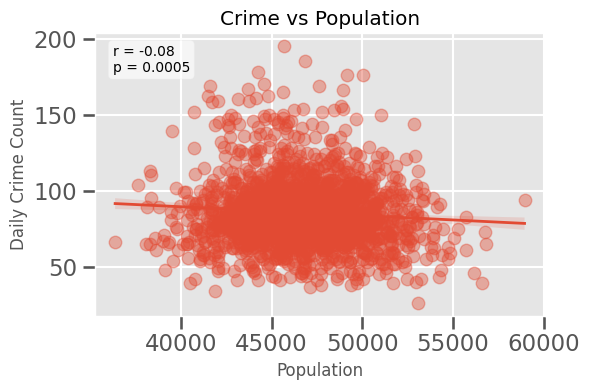

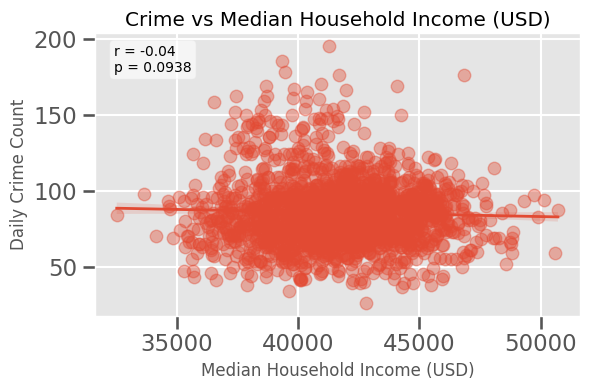

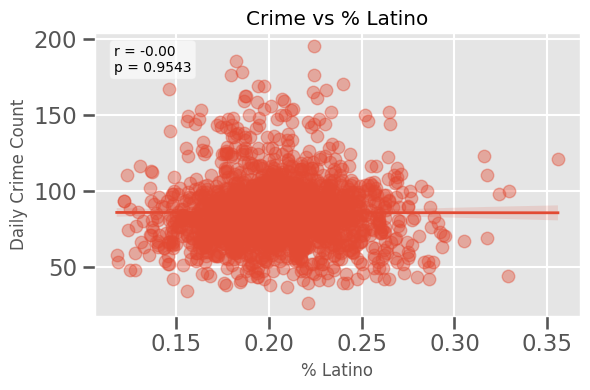

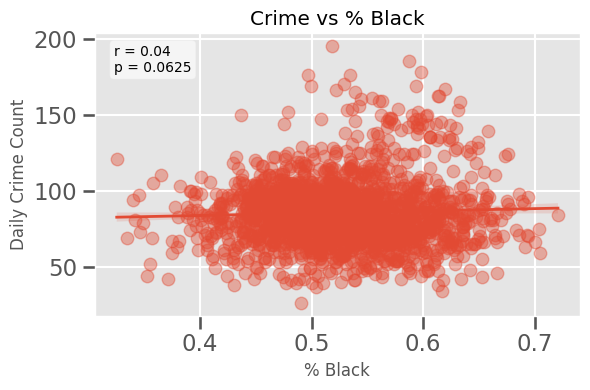

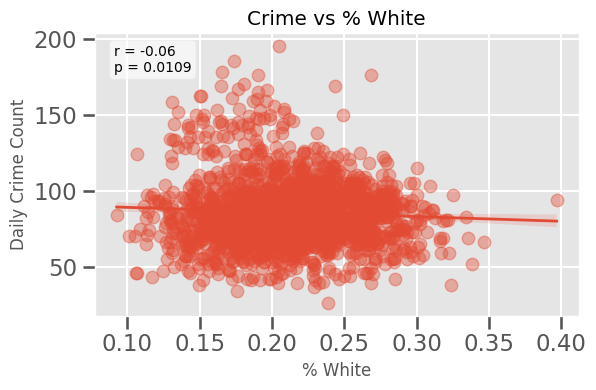

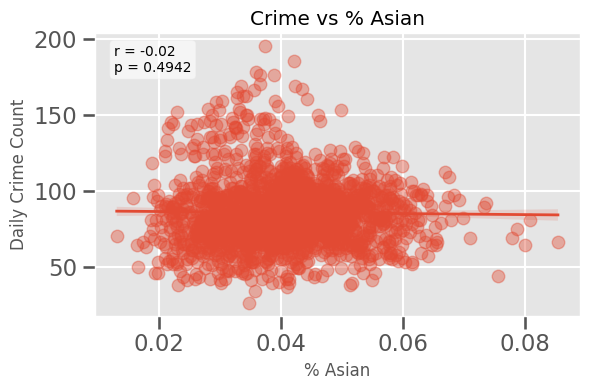

In [29]:
# =========================================================
#  DEMOGRAPHIC VARIABLES VS CRIME
# =========================================================

demo_vars = [
    ("population", "Population"),
    ("income", "Median Household Income (USD)"),
    ("latinos", "% Latino"),
    ("blacks", "% Black"),
    ("white", "% White"),
    ("asian", "% Asian")
]

# generating daily table
daily = df.groupby("date").agg(
    crimes     = ("ID", "size"),
    population = ("population", "mean"),
    income     = ("income", "mean"),
    latinos    = ("latinos", "mean"),
    blacks     = ("blacks", "mean"),
    white      = ("white", "mean"),
    asian      = ("asian", "mean")
).reset_index()

# graphs
for var, label in demo_vars:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.regplot(x=var, y="crimes", data=daily,
                scatter_kws=dict(alpha=0.4), line_kws=dict(lw=2), ax=ax)
    annotate_r_p(ax, daily[var], daily["crimes"])
    ax.set_xlabel(label); ax.set_ylabel("Daily Crime Count")
    ax.set_title(f"Crime vs {label}")
    plt.tight_layout(); plt.show()


T-test (hot vs cold days):   t = 722.19,   p = 0.0000
Chi-square (Rain vs Top-5 crimes):   chi2 = 13.25,   p = 0.0003


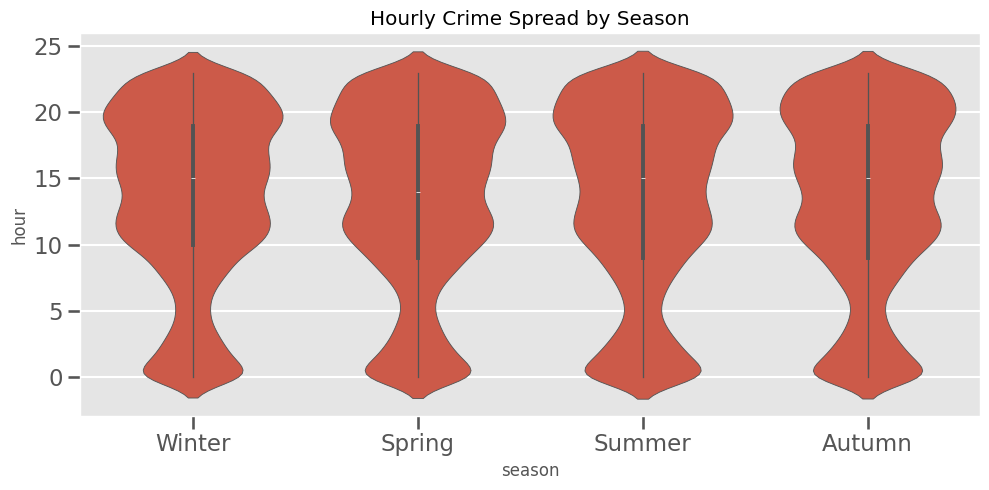

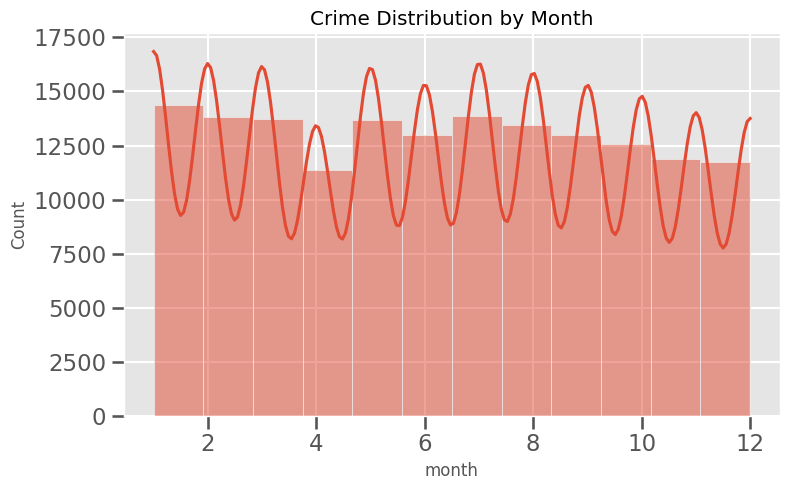

In [30]:
# =========================================================
#  HYPOTHESIS TESTING
# =========================================================

# T-test: hot vs cold days
median_temp = df["temp"].median()
hot  = df[df["temp"] >  median_temp]
cold = df[df["temp"] <= median_temp]
t, p = ttest_ind(hot["temp"], cold["temp"])
print(f"T-test (hot vs cold days):   t = {t:.2f},   p = {p:.4f}")

# Chi-square: rain vs top-5 crime types
df["rainy"] = (df["precip"] > 0).map({True: "Rain", False: "NoRain"})
top5 = df["Primary Type"].value_counts().nlargest(5).index
contingency = pd.crosstab(df["rainy"], df["Primary Type"].isin(top5))
chi2, pval, _, _ = chi2_contingency(contingency)
print(f"Chi-square (Rain vs Top-5 crimes):   chi2 = {chi2:.2f},   p = {pval:.4f}")

# Ek: Hour distribution by weather
plt.figure(figsize=(10,5))
sns.violinplot(x="season", y="hour", data=df)
plt.title("Hourly Crime Spread by Season")
plt.tight_layout(); plt.show()

# Ek: Monthly distribution
plt.figure(figsize=(8,5))
sns.histplot(df["month"], bins=12, kde=True)
plt.title("Crime Distribution by Month")
plt.tight_layout(); plt.show()



---------- DAILY OLS REGRESSION ----------
                            OLS Regression Results                            
Dep. Variable:                 crimes   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.967
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           2.67e-10
Time:                        17:01:11   Log-Likelihood:                -8189.5
No. Observations:                1828   AIC:                         1.641e+04
Df Residuals:                    1815   BIC:                         1.648e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

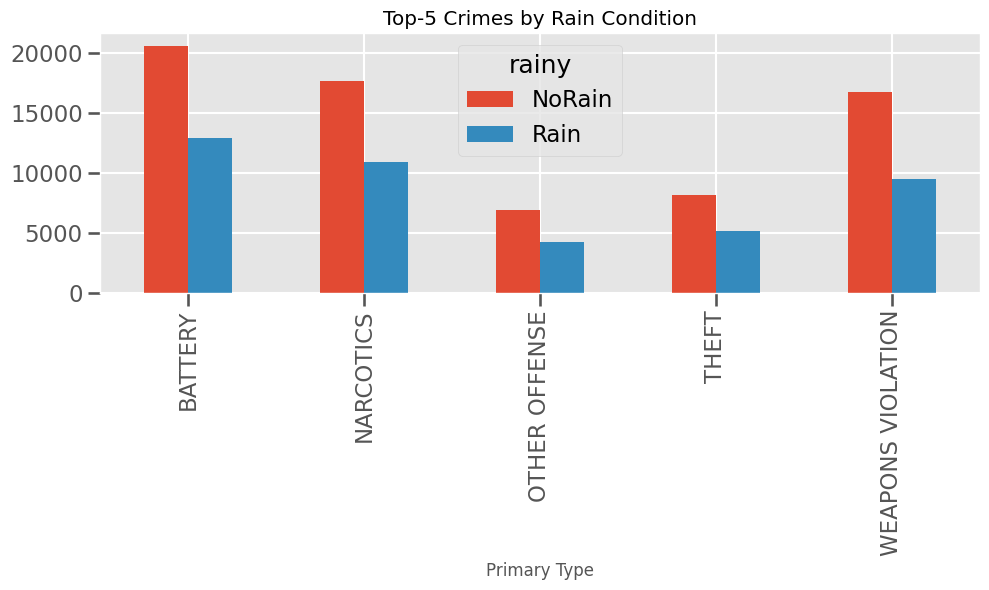

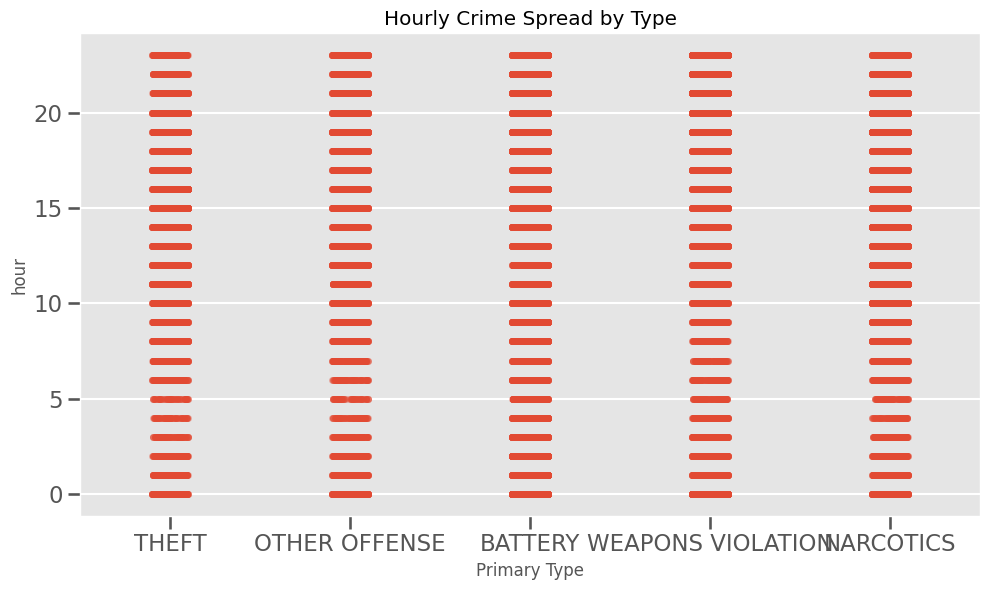

In [31]:
# =========================================================
#  MULTIVARIATE LINEAR REGRESSION (OLS)
# =========================================================


daily = df.groupby("date").agg(
    crimes     = ("ID", "size"),
    temp       = ("temp", "mean"),
    humidity   = ("humidity", "mean"),
    wind       = ("windspeed", "mean"),
    precip     = ("precip", "mean"),
    lat        = ("Latitude", "mean"),
    lon        = ("Longitude", "mean"),
    population = ("population", "mean"),
    income     = ("income", "mean"),
    latinos    = ("latinos", "mean"),
    blacks     = ("blacks", "mean"),
    white      = ("white", "mean"),
    asian      = ("asian", "mean")
).reset_index()

# OLS Regression
import statsmodels.formula.api as smf

formula = ("crimes ~ temp + humidity + wind + precip + "
           "lat + lon + population + income + latinos + blacks + white + asian")
model = smf.ols(formula, data=daily).fit()

#  modal summary
print("\n---------- DAILY OLS REGRESSION ----------")
print(model.summary())

# Ek: Top-5 crime by Rain (barplot)
crime_rain = df[df["Primary Type"].isin(top5)].groupby(["Primary Type", "rainy"]).size().unstack()
crime_rain.plot(kind="bar", figsize=(10,6))
plt.title("Top-5 Crimes by Rain Condition")
plt.tight_layout(); plt.show()

# Ek: Hour distribution by crime (stripplot)
plt.figure(figsize=(10,6))
sns.stripplot(data=df[df["Primary Type"].isin(top5)], x="Primary Type", y="hour", alpha=0.4, jitter=True)
plt.title("Hourly Crime Spread by Type")
plt.tight_layout(); plt.show()


In [32]:
# =========================================================
#  INTERACTIVE MAPS: HEATMAP & CLUSTER
# =========================================================

import folium
from folium.plugins import HeatMap, MarkerCluster

# Heatmap (crime density)
sample_heat = df[["Latitude","Longitude"]].dropna().sample(10000, random_state=42)
m_heat = folium.Map(location=[41.8781,-87.6298], zoom_start=10, tiles="CartoDB Positron")
HeatMap(sample_heat.values.tolist(), radius=8, blur=15).add_to(m_heat)
m_heat.save("chicago_crime_heatmap.html")
print("✓ Heatmap saved as chicago_crime_heatmap.html")

# MarkerCluster (top-5 crime types)
top5 = df["Primary Type"].value_counts().nlargest(5).index
sample_mark = df[df["Primary Type"].isin(top5)].dropna(subset=["Latitude","Longitude"]).sample(2000, random_state=42)

m_mark = folium.Map(location=[41.8781,-87.6298], zoom_start=11, tiles="CartoDB Positron")
cluster = MarkerCluster().add_to(m_mark)

for _, row in sample_mark.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=f'{row["Primary Type"]} | {row["DateTime"]:%Y-%m-%d %H:%M}'
    ).add_to(cluster)

m_mark.save("chicago_crime_markers.html")
print("✓ Marker map saved as chicago_crime_markers.html")


✓ Heatmap saved as chicago_crime_heatmap.html
✓ Marker map saved as chicago_crime_markers.html
